# Introduction to JumpStart - Enhance image quality guided by prompt

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use Sagemaker JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart).

In this demo notebook, we demonstrate how to use SageMaker Python SDK for Upscaling with state-of-the-art pre-trained Stable Diffusion models. Upscaling is the task of generating high resolution image given a low resolution image and a textual prompt describing the image. An image that is low resolution, blurry, and pixelated can be converted into a high resolution image that appears smoother, clearer, and more detailed. This process, called upscaling, can be applied to both real images and images generated by [text-to-image Stable Diffusion models](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/). This can be used to enhance image quality in various industries such as e-commerce and real estate, as well as for artists and photographers. Additionally, upscaling can improve the visual quality of low-resolution images when displayed on high-resolution screens.

Stable Diffusion uses an AI algorithm to upscale images, eliminating the need for manual work that may require manually filling gaps in an image. It has been trained on millions of images and can accurately predict high-resolution images, resulting in a significant increase in detail compared to traditional image upscalers. Additionally, unlike non-deep-learning techniques such as nearest neighbor, Stable Diffusion takes into account the context of the image, using a textual prompt to guide the upscaling process.

---

1. [Set Up](#1.-Set-Up)
2. [Retrieve JumpStart Artifacts & Deploy an Endpoint](#2.-Retrieve-Artifacts-&-Deploy-an-Endpoint)
3. [Query endpoint and parse response](#3.-Query-endpoint-and-parse-response)
4. [Clean up the endpoint](#4.-Clean-up-the-endpoint)

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

Note: After you’re done running the notebook, make sure to delete all resources so that all the resources that you created in the process are deleted and your billing is stopped. Code in [Clean up the endpoint](#5.-Clean-up-the-endpoint) deletes model and endpoints that are created.

### 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires ipywidgets and latest version of sagemaker.

---

In [2]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 861.2/861.2 kB 5.4 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for urllib3<1.27,>=1.25.4 from https://files.pythonhosted.org/packages/c5/05/c214b32d21c0b465506f95c4f28ccbcba15022e000b043b72b3df7728471/urllib3-1.26.16-py2.py3-none-any.whl.metad

#### Permissions and environment variables

---
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. 

---

In [3]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
aws_role

'arn:aws:iam::081978453918:role/service-role/AmazonSageMaker-ExecutionRole-20220125T111199'

### 2. Retrieve Artifacts & Deploy an Endpoint

***

Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This may take a few minutes.

***

In [5]:
model_id, model_version = "model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16", "*"

In [6]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters, instance_types
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

endpoint_name = name_from_base(f"jumpstart-example-{model_id}")

# Instances with more GPU memory supports generation of larger images.
# So, please select instance types such as ml.g5.2xlarge if you want to generate a very large image.
inference_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=model_id,
    model_version=model_version,
    scope="inference"
)

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

-----------!

In [7]:
print(f"endpoint_name: {endpoint_name}")
print(f"inference_instance_type: {inference_instance_type}")
print(f"deploy_image_uri: {deploy_image_uri}")
print(f"model_uri: {model_uri}")
print(f"model: {model}")
print(f"model_predictor: {model_predictor}")

endpoint_name: jumpstart-example-model-upscaling-stabi-2023-08-21-15-12-27-292
inference_instance_type: ml.p3.2xlarge
deploy_image_uri: 763104351884.dkr.ecr.ap-northeast-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
model_uri: s3://jumpstart-cache-prod-ap-northeast-1/stabilityai-infer/prepack/v1.0.0/infer-prepack-model-upscaling-stabilityai-stable-diffusion-x4-upscaler-fp16.tar.gz
model: <sagemaker.model.Model object at 0x7fce3999ba90>
model_predictor: Predictor: {'endpoint_name': 'jumpstart-example-model-upscaling-stabi-2023-08-21-15-12-27-292', 'sagemaker_session': <sagemaker.session.Session object at 0x7fce342201c0>, 'serializer': <sagemaker.base_serializers.IdentitySerializer object at 0x7fcdf0469220>, 'deserializer': <sagemaker.base_deserializers.BytesDeserializer object at 0x7fcdf0469280>}


### 3. Query endpoint and parse response

---
Input to the endpoint is a prompt, a low resolution image and image generation parameters in json format and encoded in `utf-8` format. Output of the endpoint is a `json` with generated images and the input prompt.

---

#### 3.1 Download example low resolution image
---
We start by downloading an example image with low resolution.

---

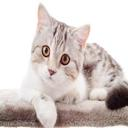

In [8]:
from IPython.display import Image

region = boto3.Session().region_name
s3_bucket = f"jumpstart-cache-prod-{region}"
key_prefix = "stabilityai-metadata/assets"
low_res_img_file_name = "low_res_cat.jpg"
s3 = boto3.client("s3")

s3.download_file(s3_bucket, f"{key_prefix}/{low_res_img_file_name}", low_res_img_file_name)

# Displaying the original image
Image(filename=low_res_img_file_name, width=632, height=632)

Next we write some helper function for querying the endpoint, parsing the response and display generated image.

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, payload, content_type, accept):
    """Query the model predictor."""

    query_response = model_predictor.predict(
        payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the generated images and prompt."""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

---
Below, we put in the example low resolution image and a prompt. You can put in any text and any image and the model generates the corresponding upscaled image. Note that model generates an image of size up to four times the original image. So, putting a very large input image may result in CUDA memory issue. To address this, either input a low resolution image or select an instance type with large CUDA memory such as ml.g5.2xlarge. 

---

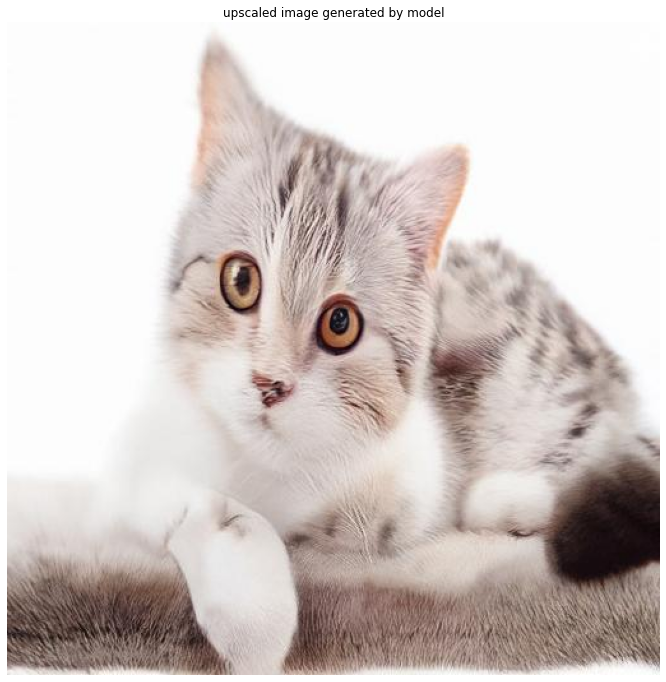

In [10]:
import base64
from PIL import Image
from io import BytesIO


# content_type = 'application/json;jpeg', endpoint expects payload to be a json with the low resolution jpeg image as bytes encoded with base64.b64 encoding.
# To send raw image to the endpoint, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open('low_res_image.jpg')).tolist()
content_type = "application/json;jpeg"


# We recommend rescaling the image of low_resolution_image such that both height and width are powers of 2.
# This can be achieved by original_image = Image.open('low_res_image.jpg'); rescaled_image = original_image.rescale((128,128)); rescaled_image.save('rescaled_image.jpg')
# Example image used in this tutorial is of size 128x128.

with open(low_res_img_file_name, "rb") as f:
    low_res_image_bytes = f.read()
encoded_image = base64.b64encode(bytearray(low_res_image_bytes)).decode()

payload = {
    "prompt": "a cat",
    "image": encoded_image,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
}


# For accept = 'application/json;jpeg', endpoint returns the jpeg image as bytes encoded with base64.b64 encoding.
# To receive raw image with rgb value set Accept = 'application/json'
accept = "application/json;jpeg"

# Note that sending or receiving payload with raw/rgb values may hit default limits for the input payload and the response size.

query_response = query(model_predictor, json.dumps(payload).encode("utf-8"), content_type, accept)
generated_images, prompt = parse_response(query_response)


# For accept = 'application/json;jpeg' mentioned above, returned image is a jpeg as bytes encoded with base64.b64 encoding.
# Here, we decode the image and display the image.
for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
    # You can save the generated image by calling generated_image_rgb.save('upscaled_cat_image.jpg')
    display_img_and_prompt(generated_image_rgb, "upscaled image generated by model")

In [ ]:
"""
query_response = b'{
    "generated_images": ["/9j/4AAQSkZJRgABAQAAAQABAAD/...tD//2Q=="], 
    "prompt": "a cat"
    }'
"""

#### Supported Parameters

***
This model supports many parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **num_inference_steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.
* **noise_level**: add noise to latent vectors before upscaling. If specified, it must be an integer.

***

### 4. Clean up the endpoint

***
After you’re done running the notebook, make sure to delete all resources created in the process to ensure that the billing is stopped.
***

In [11]:
# Delete the SageMaker endpoint
model_predictor.delete_model()
model_predictor.delete_endpoint()